<a href="https://colab.research.google.com/github/kaleem500bc/CartPole-DQNAgent-pytorch/blob/main/DQN_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PyVirtualDisplay

In [ ]:
import torch
from torch import nn
import gym
import os
from matplotlib import pyplot as plt
import numpy as np
from collections import deque
import random
import time
from IPython import display
from pyvirtualdisplay import Display
# from IPython import display
from IPython.display import clear_output
import copy
plt.ion()

In [ ]:
# make virtual screen and redirect render to this screen
# From https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh
!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
!bash ../xvfb start
os.environ['DISPLAY'] = ':1'

Selecting previously unselected package xvfb.
(Reading database ... 145483 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.8_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.8) ...
Setting up xvfb (2:1.19.6-1ubuntu4.8) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Starting virtual X frame buffer: Xvfb.


In [ ]:
class Agent:
  def __init__(self,state_size, action_size):
    self.state_size = state_size
    self.action_size = action_size

    # Discount factor
    self.gamma = 0.99

    # Probability to explore
    self.epsilon = 1.0
    # Decay probability to explore
    self.epsilon_decay = 0.995
    self.epsilon_min = 0.01

    self.learning_rate = 0.00025
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model and target model for stability 
    self.model = self.create_model()
    self.targetModel = self.create_model()

    # Initialize weights of the target model
    self.targetModel.load_state_dict(self.model.state_dict())
    self.optimizer = torch.optim.Adam(self.model.parameters(),lr=self.learning_rate)

    # The problem did not converge for L1 loss so MSE loss is used which worked
    self.criterion = nn.MSELoss()
    

  # Model that will learn the Q-function/ Agent that will play the game
  def create_model(self):
    model = nn.Sequential(
        nn.Linear(self.state_size,256),
        nn.LeakyReLU(negative_slope=0.5),
        nn.Linear(256, 128),
        nn.LeakyReLU(negative_slope=0.5),
        nn.Linear(128, self.action_size)
    )
    model.to(self.device)
    return model
    

  
  # Get action that the agent should take
  def action(self, model, state):

    # Decay the epsilon so there is less exploration in the future. 
    if self.epsilon > self.epsilon_min:
        self.epsilon *= self.epsilon_decay

    # Allow random exploration
    if np.random.rand() <= self.epsilon:
      return random.randrange(self.action_size)

    # Get action from the agent/ exploitation
    act_values = model(state).detach()
    return int(torch.argmax(act_values).item())



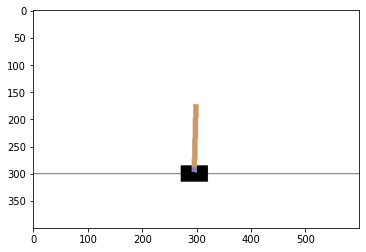

In [ ]:
# Initialize the environment
env = gym.make("CartPole-v0").env
obs = env.reset()
plt.imshow(env.render("rgb_array"))

In [ ]:
# State space of the environment
state_size = env.observation_space.shape[0]

# Action space of the agent in the environment
action_size = env.action_space.n

# Initialze the agent which composes of the model (predict value of the state) and target model
agent = Agent(state_size, action_size)

In [ ]:
# Holds the information about the episodes
class ReplayBuffer():
  def __init__(self):
    # Total number of sars (state, action, discounted reward, next state)
    self.mem_size = 1000
    self.memory = deque(maxlen=self.mem_size)



In [ ]:

# initialize replay buffer
replay_buffer = ReplayBuffer()

# Populate the replay buffer with episodes
def populate_buffer():

  # Reset the environment to initial state/ start the game
  state = env.reset()

  # Holds all the rewards, states and actions for the entire episode respectively
  rewards = []
  states = [state]
  actions = []

  discounted_factor = 0.99


  episodes = 200
  for i in range(episodes):
    done = False

    # while the episode is not ended
    while not done:

      # Action by the model or randomly select one for exploration
      act = agent.action(agent.model,torch.tensor(state,dtype=torch.float,device="cuda"))

      
      next_state, reward, done, _ = env.step(act)
      reward = reward if not done else -1

      rewards.append(reward)
      states.append(next_state)
      actions.append(act)
      state = next_state
    
    discounted_rewards = []
    # Calculate discounted rewards from current state to the next five state
    for i in range(len(rewards)):
      t = [(discounted_factor**j)*r for j,r in enumerate(rewards[i:i+5])]
      discounted_rewards.append(t)

    # discounted factor power should be calculated if the discounted rewards is less than next five state else power should be five
    # This power is used to calculate Q-value from the last state if the last state is not the final state 
    for i,(state,act,reward) in enumerate(zip(states[:-1], actions, discounted_rewards)):
      if i+5 >= len(states):
        n_state = states[len(states)-1]
        power_discounted_factor = -1
      else:
        n_state = states[i+5]
        power_discounted_factor = 5

      # Convert state to torch tensor for model processing
      state, n_state = torch.tensor(state, dtype = torch.float, device = "cuda"), torch.tensor(n_state, dtype = torch.float, device = "cuda")

      # Save in the replay buffer
      replay_buffer.memory.append((state,act,sum(reward),n_state,power_discounted_factor))

    # Reset for the next episode
    actions = []
    rewards = []
    states = []

    # Start next episode
    state = env.reset()
    states = [state]

# Populate the replay buffer
populate_buffer()

In [ ]:

# Steps to update the target model with the model weights
STEPS_UPDATE = 100

# Train the model according to q-learning
def training(agent, replay_buffer, epochs, batch_size):

  losses = []
  steps_to_update = 0

  for epoch in range(epochs):

    print("Epochs: ",epoch+1)
    
    loss_per_epoch = 0

    for batch in range(replay_buffer.mem_size// batch_size):
      
      loss = 0

      # Randomly choose the minibatch to avoid correlation between the transitions
      minibatch = random.sample(replay_buffer.memory, batch_size)

      for state, action, reward, next_state, power in minibatch:
      
        if power != -1:
          # if episode did not end then expected reward is the current reward and the future rewards from the next state
          expected_reward = reward + (agent.gamma ** power)* torch.amax(
              agent.targetModel(next_state).detach()
              )
        else:
          # If episode is ended then the current discounted reward 
          expected_reward = torch.tensor(reward, dtype = torch.float, device = "cuda")

        # Distribution of predicted Q-value from the current state for each action
        predicted_reward = agent.model(state)

        # Take the Q-value for the action taken
        predicted_reward = predicted_reward[action] 

        loss = agent.criterion(predicted_reward,expected_reward)
        # Calculate the gradient and accumulate it
        loss.backward()
        loss_per_epoch += loss.item()

      
      for param in agent.model.parameters():
        param.grad.data.clamp_(-1, 1)

      # Update the model weights by the accumulated gradient of the batch
      agent.optimizer.step()

      # Flush the gradient for the next batch SGD
      agent.optimizer.zero_grad()
      
      

      
      # Update the target model by the weights of the model
      steps_to_update += 1
      if (steps_to_update) % STEPS_UPDATE == 0:
        agent.targetModel.load_state_dict(agent.model.state_dict())
    
    # After 10 epochs populate the replay buffer with new training data
    if (epoch+1) % 10 == 0:
      populate_buffer()
      
      

    losses.append(loss_per_epoch)
  
  return losses
        

In [ ]:
loss = training(agent, replay_buffer, epochs = 50, batch_size = 10)

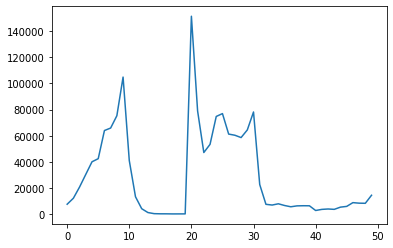

In [ ]:
# After every 10 epochs the model is trained with the new training data
plt.plot(loss)

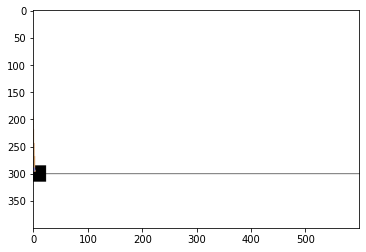

347


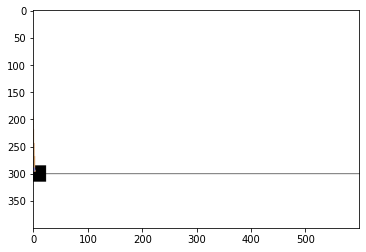

In [ ]:
# Test the trained model in the environment
avg_score = 0
# for i in range(10):
state = env.reset()
done = False
display_img = plt.imshow(env.render("rgb_array"))

while not done:
  state = torch.tensor(state,dtype=torch.float).to("cuda")
  action = agent.model(state)
  action = int(torch.argmax(action).item())
  state, reward, done, _ = env.step(action)
  display_img.set_data(env.render("rgb_array"))
  clear_output(wait=True)
  display.display(plt.gcf())
  avg_score += 1
print(avg_score)